In [4]:
import csv
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.layers import Input, Conv2D, Add, ReLU, BatchNormalization, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
#from tensorflow.keras.applications import VGG19 # ДЛЯ ПРЕЦЕПТУАЛЬНИХ ВТРАТ
from tqdm import tqdm
from sklearn.utils import shuffle

import random
plt.rcParams['figure.figsize'] = [15, 10]


## функція для завантаження датасету

In [5]:
def load_list_of_data(image_dir):
    dataset = []
    
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: {img_path} could not be loaded.")
                continue  # Пропускаємо файл, якщо не вдалося його завантажити
            
            #зміна розмірів один раз на весь датасет, щоб не робити це кожну епоху, бо більші розміри в мене комп не тяне.
            img_h, img_w, ch = img.shape
            if img_h > 850 or img_w > 850:
                if img_h >= img_w:
                    img = cv2.resize(img, (round(img_w * (850 / img_h)), 850))
                else:
                    img = cv2.resize(img, (850, round(img_h * (850 / img_w))))
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # в цій функції можна залишити тільки список шляхів, 
            # а завантаження фото можна перенести в наступну функцію to_batch_and_augment
            # залишив так як є, бо оперативки хватало, а прогружать кожен раз батч фоток з нуля довго
            dataset.append(img)

    return dataset

## Функція генератор. Подає батч фотографій

In [6]:
def to_batch_and_augment(dataset, batch_size):
    while True:
        dataset = shuffle(dataset)  # Перемішуємо зображення

        for idx in range(0, len(dataset), batch_size):
            batch = dataset[idx:idx + batch_size]
            batch_out = []

            for img in batch:

                # РАНДОМНИЙ РОЗМІР КАРТИНКИ
                # розмір картинки в діапазоні від 300 до 850, бо нехватає відеопамяті
                img_h, img_w, ch = img.shape
                if img_h <= img_w:
                    new_size_w = random.randint(300, img_w)
                    new_size_h = round((new_size_w / img_w) * img_h)
                else:
                    new_size_h = random.randint(300, img_h)
                    new_size_w = round((new_size_h / img_h) * img_w)

                high_res_img = cv2.resize(img, (new_size_w, new_size_h))

                
                # СТВОРЕННЯ LOW_RES КАРТИНКИ
                # після того як ми отримали рандомний розмір high_res_img ми отримуємо low_res_img 
                low_res_img = cv2.resize(high_res_img, (round(new_size_w / 2), round(new_size_h / 2)))
                low_res_img = cv2.resize(low_res_img, (new_size_w, new_size_h))

                # АУГМЕНТАЦІЇ
                # фліп, поворот
                if np.random.rand() > 0.5:
                    high_res_img = np.fliplr(high_res_img)
                    low_res_img = np.fliplr(low_res_img)

                if np.random.rand() > 0.5:
                    high_res_img = np.flipud(high_res_img)
                    low_res_img = np.flipud(low_res_img)

                random_rotation = np.random.choice([0, 1, 2, 3])
                high_res_img = np.rot90(high_res_img, k=random_rotation)
                low_res_img = np.rot90(low_res_img, k=random_rotation)

                # НОРМАЛІЗАЦІЯ В ДІАПАЗОН ВІД 0 ДО 1
                # був варант спробувати ще зробити модель в діапазоні від -1 до 1, 
                # але в мене помилки полізли і часу взагалі не залишилось

                high_res_img = high_res_img.astype(np.float32)
                high_res_img = high_res_img / 255

                low_res_img = low_res_img.astype(np.float32)
                low_res_img = low_res_img / 255
            
                
                images_pair = (low_res_img, high_res_img)
                batch_out.append(images_pair)

            if len(batch_out) > 0:
                yield batch_out
            batch_out = []

## модель генератора

In [7]:
# модель побудована таким чином, що може приймати різні розміри зображень
def build_generator(input_shape):
    inputs = Input(shape=input_shape)
    
    # Перший шар
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = ReLU()(x)
    
    # Блоки Residual Blocks
    for _ in range(8):  # більше residual blocks не тягне комп ні в мене ні в google colab
        res = x
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = Add()([x, res])  # Додавання residual connection
    
    # Вихідний конволюційний шар
    x = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
    
    model = Model(inputs, x)
    return model

# Створюємо генератор
generator = build_generator((None, None, 3))
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      1,792 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None,      │          0 │ conv2d[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │     36,928 │ re_lu[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, None,      │          0 │ batch_normalizat… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_1[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ conv2d_2[0][0],   │
│                     │ None, 64)         │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     36,928 │ add[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, None,      │          0 │ batch_normalizat… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_2[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ conv2d_4[0][0],   │
│                     │ None, 64)         │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     36,928 │ add_1[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, None,      │          0 │ batch_normalizat… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │     36,928 │ re_lu_3[0][0]   

 Total params: 596,419 (2.28 MB)

 Trainable params: 595,395 (2.27 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Модель дескримінатора

In [9]:
# дескримінатор також може приймати різні розміри зображень
def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=2, padding='same')(inputs)
    x = ReLU()(x)
    
    x = GlobalAveragePooling2D()(x) 
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, x)
    return model

discriminator = build_discriminator((None, None, 3))
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857 (7.25 KB)

 Trainable params: 1,857 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

## Функція для розразунку loss прецептуальних втрат
### не використовував бо через неї тривалість епохи виросла з 12хв/епоха до 40хв/епоха, але функція працює
#### щоб використати
   - потрібно зняти коментар знаступного блоку коду, 
   - розкоментувати імпорт vgg, 
   - розкоментувати `perceptual_loss` в функції`generator_loss`
   - додати `perceptual_loss` до `total_loss`

In [47]:
# # Завантаження VGG19, попередньо навченого на ImageNet
# vgg = VGG19(include_top=False, weights="imagenet")
# # Вибір шару, який відповідає за високорівневі ознаки (наприклад, 'block5_conv4')
# selected_layer = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer("block5_conv4").output)
# selected_layer.trainable = False

# def perceptual_loss_f(real_image, generated_image):
#     # Отримання ознак для реального і згенерованого зображення
#     real_features = selected_layer(real_image)
#     generated_features = selected_layer(generated_image)

#     # Перцептуальна втрата — різниця між ознаками
#     return tf.reduce_mean(tf.abs(real_features - generated_features))


80134624/80134624 [==============================] - 3s 0us/step


In [8]:
def generator_loss(fake_output, real_image, generated_image):
    # Втрата контенту
    #або середня абсолютна різниця
    content_loss = tf.reduce_mean(tf.abs(real_image - generated_image))
    #або середня квадратична
    #content_loss = tf.reduce_mean(tf.square(real_image - generated_image))


    # перцептуальні втрати  (не тягне комп'ютер)
    #perceptual_loss = perceptual_loss_f(real_image, generated_image)
    
    # Втрата дискримінатора (класична крос-ентропія)
    adversarial_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(fake_output), logits=fake_output))
    
    total_loss = content_loss + 1e-3 * adversarial_loss #+ 0,01 * perceptual_loss    # Комбінація втрат генератора
    
    return total_loss

def discriminator_loss(real_output, fake_output):
    # класична крос-ентропія (реальна фотка одинички)
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(real_output), logits=real_output))
    # класична крос-ентропія (згенерована фотка нулики)
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.zeros_like(fake_output), logits=fake_output))
    
    total_loss = (real_loss + fake_loss) * 0.5  # Комбінація втрат дескримінатора
    return total_loss

## Завантаження моделі для продовження тренування

In [5]:
# generator = tf.keras.models.load_model('./demo_generator_model200.h5')
# discriminator = tf.keras.models.load_model('./demo_discriminator_model200.h5')

## Функція запису всіх loss в .csv файл

In [10]:
def write_csv(all_loss_gen, all_loss_disc, all_loss_gen_val, all_loss_disc_val):  
    # Перевіряємо, чи існує файл
    file_exists = os.path.isfile('data.csv')

    # Відкриваємо файл у режимі "append" (доповнення)
    with open('data.csv', mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Якщо файл не існує, додаємо підписи колонок
        if not file_exists:
            writer.writerow(['all_loss_gen', 'all_loss_disc', 'all_loss_gen_val', 'all_loss_disc_val'])
        
        # Додаємо нові дані
        writer.writerow([all_loss_gen, all_loss_disc, all_loss_gen_val, all_loss_disc_val])

## Присвоєння оптимізаторів, ітерація епохи тренування та валідації (train_step, val_step). І саме тренування

In [ ]:
# Оптимізатори для генератора та дискримінатора
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# крок трейну
def train_step(low_res, high_res):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Генерація зображень
        generated_image = generator(low_res, training=True)
        
        # Оцінка дискримінатором
        real_output = discriminator(high_res, training=True)
        fake_output = discriminator(generated_image, training=True)
        
        # Обчислення втрат
        gen_loss = generator_loss(fake_output, high_res, generated_image)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Обчислення градієнтів для генератора та дискримінатора
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Оновлення параметрів
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# крок валідації
# Те саме що й train_step, але без оновлення вагів і на валідаційному датасеті
def val_step(low_res, high_res):
    # Генерація зображень
    generated_image = generator(low_res, training=False)
    
    # Оцінка дискримінатором
    real_output = discriminator(high_res, training=False)
    fake_output = discriminator(generated_image, training=False)
    
    # Обчислення втрат
    gen_loss = generator_loss(fake_output, high_res, generated_image)
    disc_loss = discriminator_loss(real_output, fake_output)
    return gen_loss, disc_loss


# Навчальний цикл
def train(dataset, dataset_val, epochs, batch_size):
    dataset = load_list_of_data(dataset) # завантаження в пам'ять всього датасету трейну
    dataset_val = load_list_of_data(dataset_val) # завантаження в пам'ять всього датасету валідації
    batch_step = to_batch_and_augment(dataset, batch_size) # ініціалізація генератора для трейну 
    batch_step_val = to_batch_and_augment(dataset_val, batch_size) # ініціалізація генератора для валідації 
    # процес навчання
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoh_loss_gen = []
        epoh_loss_disc = []
        epoh_loss_gen_val = []
        epoh_loss_disc_val = []


        print('ОБРОБКА АУГМЕНТАЦІЙ')
        batch_epoch = []
        # зроблено щоб в початку епохи прогрузити відразу весь аугментований сет
        # можна цього не робити. Потрібно видалити цю частину, 
        # і в наступномій частині замінити batch = batch_epoch[i] на batch = next(batch_step)
        for i in tqdm(range(0, len(dataset), batch_size)):
            batch_epoch.append(next(batch_step))


        print('ТРЕЙН')
        for i in tqdm(range(0, len(dataset), batch_size)): # кількість ітерацій в епохі відповідно розміру batch_size
            batch = batch_epoch[i]
            low_res_batch, high_res_batch = zip(*batch) # розпаковка low_res_batch і high_res_batch трейну
            # КОНВЕРТАЦІЯ В ТЕНЗОР
            # я розумію, що тензор очікує однакові розмірності елементів, тому в мене batch_size = 1
            # це можна було б вирішити на етапі генератора аугментацій, подаючи на навчання батчі з однакових розмірів
            low_res_batch = tf.convert_to_tensor(low_res_batch) 
            high_res_batch = tf.convert_to_tensor(high_res_batch) 
            # проводимо тренування з батчем і отримуємо loss
            gen_loss, disc_loss = train_step(low_res_batch, high_res_batch)
            # збираємо loss всіх ітерацій в епохі
            epoh_loss_gen.append(gen_loss)
            epoh_loss_disc.append(disc_loss)
        
        # виводимо середні train loss на епоху
        print(f"Step {i+1}, Gen Loss: {np.mean(epoh_loss_gen)}, Disc Loss: {np.mean(epoh_loss_disc)}")

        # видаляємо з пам'яті аугментований датасет
        del batch_epoch

        # кожну п'яту епоху зберігаємо модель
        if (epoch+1) % 5 == 0:
            generator.save(f"./models/generator_model{epoch+1}.keras")
            discriminator.save(f"./models/discriminator_model{epoch+1}.keras")



        print('ВАЛІДАЦІЯ')
        for i in tqdm(range(0, len(dataset_val), batch_size)):
            batch = next(batch_step_val)
            low_res_batch, high_res_batch = zip(*batch) # розпаковка low_res_batch і high_res_batch валідації
            # КОНВЕРТАЦІЯ В ТЕНЗОР
            low_res_batch = tf.convert_to_tensor(low_res_batch)
            high_res_batch = tf.convert_to_tensor(high_res_batch)
            # проводимо оцінку на валідаційному сеті і отримуємо loss
            gen_loss, disc_loss = val_step(low_res_batch, high_res_batch)
            # збираємо loss всіх ітерацій в епохі
            epoh_loss_gen_val.append(gen_loss)
            epoh_loss_disc_val.append(disc_loss)
        
        # виводимо середні val loss на епоху
        print(f"Step {i+1}, Val Gen Loss: {np.mean(epoh_loss_gen_val)}, Val Disc Loss: {np.mean(epoh_loss_disc_val)}")
        

        # записуємо всі loss в .csv файл
        write_csv(np.mean(epoh_loss_gen), np.mean(epoh_loss_disc), np.mean(epoh_loss_gen_val), np.mean(epoh_loss_disc_val))

        
            

# Запуск тренування
with tf.device('/GPU:0'):
    train(dataset="./train", dataset_val="./val", epochs=200, batch_size=1)  
print('train is over')

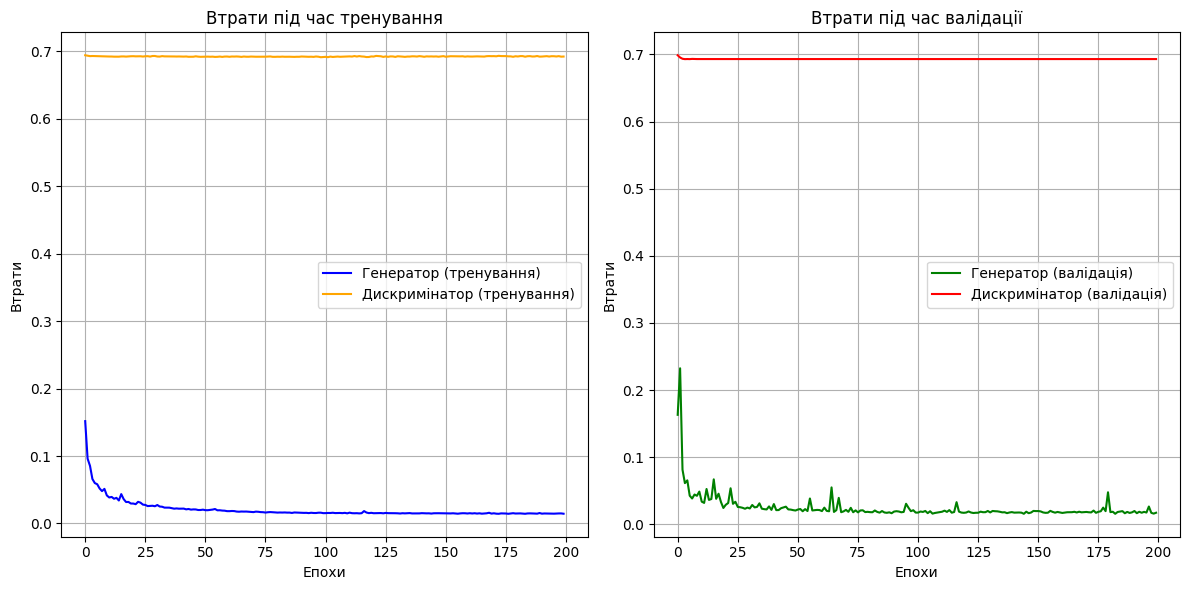

In [12]:
import csv
import matplotlib.pyplot as plt

# Читання даних з файлу data.csv
file_name = 'demo_train.csv'

# Зчитування даних у списки
with open(file_name, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Пропустити заголовок
    data = list(zip(*[[float(value) for value in row] for row in reader]))

all_loss_gen, all_loss_disc, all_loss_gen_val, all_loss_disc_val = data

# Функція для побудови графіка
def plot_losses(ax, losses, labels, title, colors):
    for loss, label, color in zip(losses, labels, colors):
        ax.plot(loss, label=label, color=color)
    ax.set_title(title)
    ax.set_xlabel("Епохи")
    ax.set_ylabel("Втрати")
    ax.legend()
    ax.grid(True)

# Побудова графіків
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_losses(
    axes[0],
    [all_loss_gen, all_loss_disc],
    ["Генератор (тренування)", "Дискримінатор (тренування)"],
    "Втрати під час тренування",
    ['blue', 'orange']
)

plot_losses(
    axes[1],
    [all_loss_gen_val, all_loss_disc_val],
    ["Генератор (валідація)", "Дискримінатор (валідація)"],
    "Втрати під час валідації",
    ['green', 'red']
)

plt.tight_layout()
plt.show()

## тест результатів

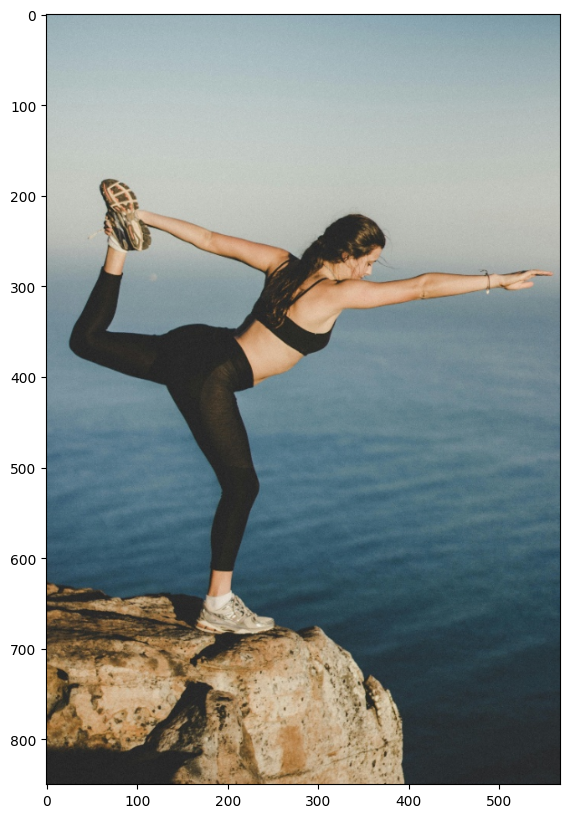

In [13]:
# завантаження датасету для тесту 
dataset_for_test = load_list_of_data("./val") # можна трейновий сет, можна валідаційний, або свій
plt.imshow(dataset_for_test[0])

## ініціалізація такого ж генератора для тесту, який був використаний для тренування 

In [14]:
dataset_aug_for_test = to_batch_and_augment(dataset_for_test, batch_size=3) #для тесту можна вказувати любий batch_size

## тест, який зберігає результати в папку test

In [ ]:
# Зберігаємо фото, бо по збереженим можна краще оцінити результат

batch_for_test = next(dataset_aug_for_test) # отримуємо батч картинок

# Кількість пар у батчі
batch_size_for_test = len(batch_for_test)

for i, (low_res_img, high_res_img) in enumerate(batch_for_test):
    # Низькороздільне зображення
    cv2.imwrite(f'./test/{i}low.jpg', cv2.cvtColor((low_res_img*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

    # Високороздільне зображення
    cv2.imwrite(f'./test/{i}hight.jpg', cv2.cvtColor((high_res_img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

    # Передбачення генератора для низькороздільного зображення
    pred_img = generator.predict(np.expand_dims(low_res_img, axis=0))  # Прогноз для одного зображення
    pred_img = np.squeeze(pred_img)  # Видаляємо додаткову вимірність
    cv2.imwrite(f'./test/{i}pred.jpg', cv2.cvtColor((pred_img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))


## Для використання готової моделі потрібно:
   - завантажити фотографію в rgb
   - збільшити фото в 4 рази (`w*2`,`h*2`)
   - перевести фото в діапазон від 0 до 1: astype=float32, img = img\255 
   - зробити на цьому фото predict моделі
   - зберегти результат (або перевести результат назад в uint8 і зберегти)

Для порівняння можна зберегти результат просто збільшеного фото і обробленого моделлю.

приклад коду наведено в файлі use_model.ipynb